In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import glob
from decimal import Decimal
from eofs.xarray import Eof
from bin_functions import bin_TS, select_basin, select_basin_EN4
from eof_functions import compute_eof, proj_on_eof, plot_eof_basin
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('ggplot')

In [3]:
reso = [0.01,0.02,0.025,0.03,0.04,0.05,0.1]
c = 10
deltaS = reso[1]
deltaT = c*deltaS
sbins = np.arange(30,40, deltaS) 
tbins = np.arange(-2, 33, deltaT)

## Read 4D annual means, select regions and bin

In [4]:
# -- Read all data in dask
datadir = '/data/ysilvy/CMIP5_annual/4D/'
# PiControl (multiple files)
dsT_piC = xr.open_mfdataset(datadir+'thetao*piControl*.nc',combine='by_coords',data_vars='minimal'
                            ,coords='minimal', compat='override',drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS_piC = xr.open_mfdataset(datadir+'so*piControl*.nc',combine='by_coords',data_vars='minimal'
                            ,coords='minimal', compat='override',drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
# Ensemble mean hist+rcp85
dsT_ensm = xr.open_dataset(glob.glob(datadir+'thetao*ensm*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS_ensm = xr.open_dataset(glob.glob(datadir+'so*ensm*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
# Hist+rcp85 members
dsT1 = xr.open_dataset(glob.glob(datadir+'thetao*historical-rcp85_r1i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS1 = xr.open_dataset(glob.glob(datadir+'so*historical-rcp85_r1i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsT2 = xr.open_dataset(glob.glob(datadir+'thetao*historical-rcp85_r2i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS2 = xr.open_dataset(glob.glob(datadir+'so*historical-rcp85_r2i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsT3 = xr.open_dataset(glob.glob(datadir+'thetao*historical-rcp85_r3i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS3 = xr.open_dataset(glob.glob(datadir+'so*historical-rcp85_r3i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsT4 = xr.open_dataset(glob.glob(datadir+'thetao*historical-rcp85_r4i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS4 = xr.open_dataset(glob.glob(datadir+'so*historical-rcp85_r4i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
# 1pctCO2
dsTCO2 = xr.open_dataset(glob.glob(datadir+'thetao*1pctCO2*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsSCO2 = xr.open_dataset(glob.glob(datadir+'so*1pctCO2*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
# EN4
dsEN4 = xr.open_dataset('/data/ysilvy/EN4/180723_EN4.2.1.g10_yearly_TAndS_190001-201806_5-5350m.nc',chunks={'time':50}).sel(time=slice('1900','2017'))

In [5]:
# -- Read volume (same for all experiments with IPSLCM5)
dirvol = '/bdd/CMIP5/output/IPSL/IPSL-CM5A-LR/piControl/fx/ocean/fx/r0i0p0/latest/volcello/'
dsvol = xr.open_dataset(dirvol+'volcello_fx_IPSL-CM5A-LR_piControl_r0i0p0.nc')
dsvol = dsvol.reindex(lev=list(dsT_piC.lev))
dsvol = dsvol.drop('j')
dsvol = dsvol.drop('i')
dsvol = dsvol.rename({'j': 'y','i': 'x'})

In [6]:
# -- Create EN4 volume
farea = xr.open_dataset('/data/ysilvy/EN4/obs.EN4.historical.r0i0p0.mo.ocn.Omon.areacello.ver-1.latestX.nc')
farea = farea.squeeze('depth')
farea = farea.squeeze('time')
area = xr.DataArray(farea.areacello.data,dims=('lat','lon'),coords=(dsEN4.lat,dsEN4.lon))

dz = dsEN4.depth_bnds[:,1] - dsEN4.depth_bnds[:,0]
dVEN4 = dz * area
dVEN4 = dVEN4.where(~np.isnan(dsEN4.thetao.isel(time=0))) # Correct for bathymetry

In [7]:
regions = ['southern_ocean','atlantic','pacific','indian']
# -- Read basin mask (orca2)
mask = xr.open_dataset('/data/ysilvy/orca2_v2_subbasins_grid_T.nc').squeeze()

In [8]:
# -- Read WOD13 basin mask
maskEN4 = xr.open_dataset('/data/ysilvy/170224_WOD13_masks.nc').basinmask3

In [9]:
# -- Rearrange lat and lon dimensions of the basinmask so it matches dsEN4 coordinates
maskEN4 = maskEN4.rename({'latitude':'lat','longitude':'lon'})
maskEN4['lon'] = maskEN4['lon'] % 360 # Modulo 360 to have only positive numbers
maskEN4 = maskEN4.sortby(maskEN4.lon) # Sort in ascending lon coordinate
maskEN4 = maskEN4.interp_like(dsEN4) # Interpolate onto same lat and lon coordinates as dsEN4

In [10]:
# -- Datasets containing 4 basins
dsT_ensm_reg = select_basin(dsT_ensm,mask)
dsS_ensm_reg = select_basin(dsS_ensm,mask)
dsT_piC_reg = select_basin(dsT_piC,mask)
dsS_piC_reg = select_basin(dsS_piC,mask)
dsT1_reg = select_basin(dsT1,mask)
dsS1_reg = select_basin(dsS1,mask)
dsT2_reg = select_basin(dsT2,mask)
dsS2_reg = select_basin(dsS2,mask)
dsT3_reg = select_basin(dsT3,mask)
dsS3_reg = select_basin(dsS3,mask)
dsT4_reg = select_basin(dsT4,mask)
dsS4_reg = select_basin(dsS4,mask)
dsTCO2_reg = select_basin(dsTCO2,mask)
dsSCO2_reg = select_basin(dsSCO2,mask)
dsEN4_reg = select_basin_EN4(dsEN4,maskEN4)

In [11]:
# -- Bin in T/S volume
def bin_basins(S,T,vol,sbins,tbins):
    V_reg = ['']*4
    for i in range(4):
        V_reg[i] = bin_TS(S.isel(region=i),T.isel(region=i),vol,sbins,tbins)
    return V_reg

In [12]:
Vensm_reg = bin_basins(dsS_ensm_reg,dsT_ensm_reg,dsvol.volcello,sbins,tbins)
VpiC_reg = bin_basins(dsS_piC_reg,dsT_piC_reg,dsvol.volcello,sbins,tbins)
V1_reg = bin_basins(dsS1_reg,dsT1_reg,dsvol.volcello,sbins,tbins)
V2_reg = bin_basins(dsS2_reg,dsT2_reg,dsvol.volcello,sbins,tbins)
V3_reg = bin_basins(dsS3_reg,dsT3_reg,dsvol.volcello,sbins,tbins)
V4_reg = bin_basins(dsS4_reg,dsT4_reg,dsvol.volcello,sbins,tbins)
VCO2_reg = bin_basins(dsSCO2_reg,dsTCO2_reg,dsvol.volcello,sbins,tbins)
VEN4_reg = bin_basins(dsEN4_reg,dsEN4_reg,dVEN4,sbins,tbins)

## EOFs: build a base from the ensemble mean and project others onto it

In [13]:
# import importlib
# import eof_functions
# importlib.reload(eof_functions)

### Southern Ocean 

In [14]:
# -- EOF Ensemble mean
solver_so = compute_eof(Vensm_reg[0])
 # -- Project 4 members, piC and 1pctCO2
pseudo_pcs_1_so = proj_on_eof(V1_reg[0],solver_so)
pseudo_pcs_2_so = proj_on_eof(V2_reg[0],solver_so)
pseudo_pcs_3_so = proj_on_eof(V3_reg[0],solver_so)
pseudo_pcs_4_so = proj_on_eof(V4_reg[0],solver_so)

pseudo_pcs_piC1_so = proj_on_eof(VpiC_reg[0].isel(time=slice(0,250)),solver_so)
pseudo_pcs_piC2_so = proj_on_eof(VpiC_reg[0].isel(time=slice(250,500)),solver_so)
pseudo_pcs_piC3_so = proj_on_eof(VpiC_reg[0].isel(time=slice(500,750)),solver_so)
pseudo_pcs_piC4_so = proj_on_eof(VpiC_reg[0].isel(time=slice(750,1000)),solver_so)

pseudo_pcs_CO2_so = proj_on_eof(VCO2_reg[0],solver_so)

pseudo_pcs_EN4_so = proj_on_eof(VEN4_reg[0],solver_so)

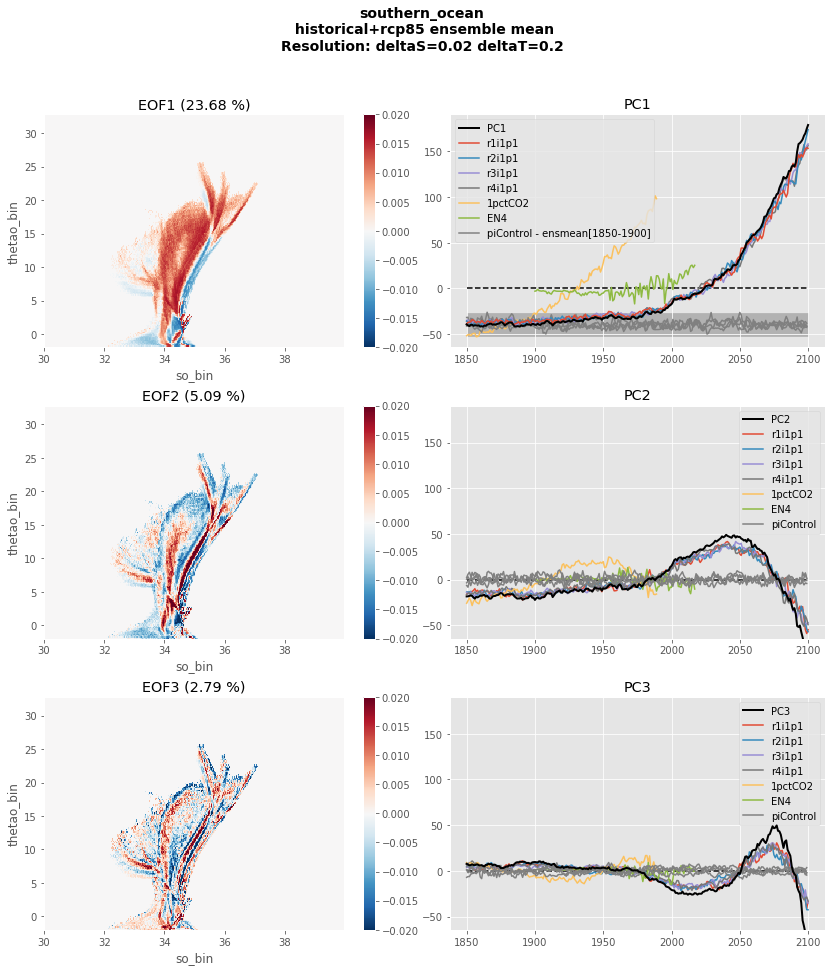

In [17]:
plot_eof_basin(0,solver_so,pseudo_pcs_1_so,pseudo_pcs_2_so,pseudo_pcs_3_so,pseudo_pcs_4_so,
                pseudo_pcs_piC1_so,pseudo_pcs_piC2_so,pseudo_pcs_piC3_so,pseudo_pcs_piC4_so,
               pseudo_pcs_CO2_so,pseudo_pcs_EN4_so)

### Atlantic 

In [18]:
# -- EOF Ensemble mean
solver_atl = compute_eof(Vensm_reg[1])
 # -- Project 4 members, piC and 1pctCO2
pseudo_pcs_1_atl = proj_on_eof(V1_reg[1],solver_atl)
pseudo_pcs_2_atl = proj_on_eof(V2_reg[1],solver_atl)
pseudo_pcs_3_atl = proj_on_eof(V3_reg[1],solver_atl)
pseudo_pcs_4_atl = proj_on_eof(V4_reg[1],solver_atl)

pseudo_pcs_piC1_atl = proj_on_eof(VpiC_reg[1].isel(time=slice(0,250)),solver_atl)
pseudo_pcs_piC2_atl = proj_on_eof(VpiC_reg[1].isel(time=slice(250,500)),solver_atl)
pseudo_pcs_piC3_atl = proj_on_eof(VpiC_reg[1].isel(time=slice(500,750)),solver_atl)
pseudo_pcs_piC4_atl = proj_on_eof(VpiC_reg[1].isel(time=slice(750,1000)),solver_atl)

pseudo_pcs_CO2_atl = proj_on_eof(VCO2_reg[1],solver_atl)

pseudo_pcs_EN4_atl = proj_on_eof(VEN4_reg[1],solver_atl)

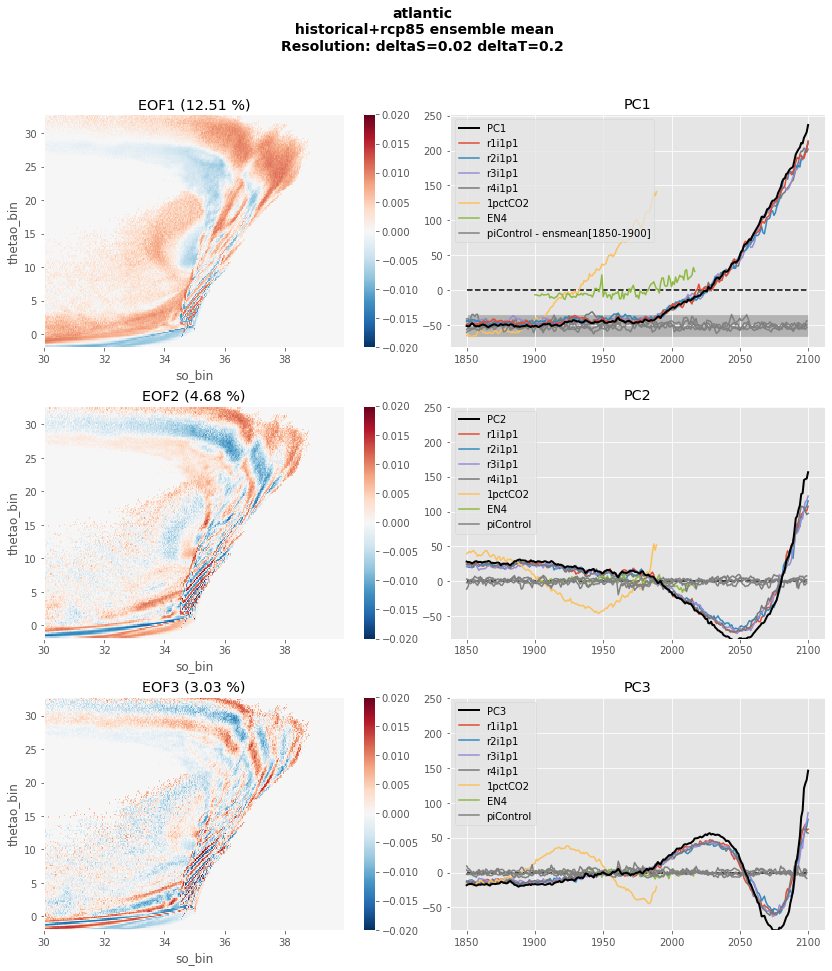

In [19]:
plot_eof_basin(1,solver_atl,pseudo_pcs_1_atl,pseudo_pcs_2_atl,pseudo_pcs_3_atl,pseudo_pcs_4_atl,
                pseudo_pcs_piC1_atl,pseudo_pcs_piC2_atl,pseudo_pcs_piC3_atl,pseudo_pcs_piC4_atl,
               pseudo_pcs_CO2_atl,pseudo_pcs_EN4_atl)

### Pacific 

In [20]:
# -- EOF Ensemble mean
solver_pac = compute_eof(Vensm_reg[2])
 # -- Project 4 members, piC and 1pctCO2
pseudo_pcs_1_pac = proj_on_eof(V1_reg[2],solver_pac)
pseudo_pcs_2_pac = proj_on_eof(V2_reg[2],solver_pac)
pseudo_pcs_3_pac = proj_on_eof(V3_reg[2],solver_pac)
pseudo_pcs_4_pac = proj_on_eof(V4_reg[2],solver_pac)

pseudo_pcs_piC1_pac = proj_on_eof(VpiC_reg[2].isel(time=slice(0,250)),solver_pac)
pseudo_pcs_piC2_pac = proj_on_eof(VpiC_reg[2].isel(time=slice(250,500)),solver_pac)
pseudo_pcs_piC3_pac = proj_on_eof(VpiC_reg[2].isel(time=slice(500,750)),solver_pac)
pseudo_pcs_piC4_pac = proj_on_eof(VpiC_reg[2].isel(time=slice(750,1000)),solver_pac)

pseudo_pcs_CO2_pac = proj_on_eof(VCO2_reg[2],solver_pac)

pseudo_pcs_EN4_pac = proj_on_eof(VEN4_reg[2],solver_pac)

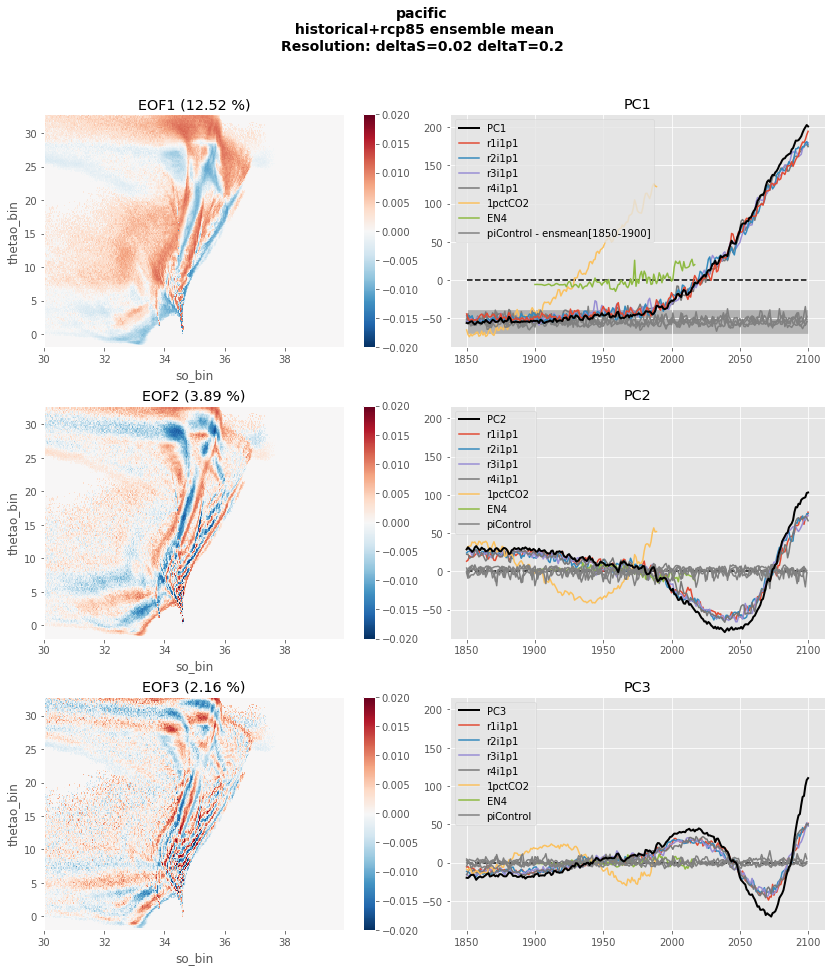

In [21]:
plot_eof_basin(2,solver_pac,pseudo_pcs_1_pac,pseudo_pcs_2_pac,pseudo_pcs_3_pac,pseudo_pcs_4_pac,
                pseudo_pcs_piC1_pac,pseudo_pcs_piC2_pac,pseudo_pcs_piC3_pac,pseudo_pcs_piC4_pac,
               pseudo_pcs_CO2_pac,pseudo_pcs_EN4_pac)

### Indian

In [22]:
# -- EOF Ensemble mean
solver_ind = compute_eof(Vensm_reg[3])
 # -- Project 4 members, piC and 1pctCO2
pseudo_pcs_1_ind = proj_on_eof(V1_reg[3],solver_ind)
pseudo_pcs_2_ind = proj_on_eof(V2_reg[3],solver_ind)
pseudo_pcs_3_ind = proj_on_eof(V3_reg[3],solver_ind)
pseudo_pcs_4_ind = proj_on_eof(V4_reg[3],solver_ind)

pseudo_pcs_piC1_ind = proj_on_eof(VpiC_reg[3].isel(time=slice(0,250)),solver_ind)
pseudo_pcs_piC2_ind = proj_on_eof(VpiC_reg[3].isel(time=slice(250,500)),solver_ind)
pseudo_pcs_piC3_ind = proj_on_eof(VpiC_reg[3].isel(time=slice(500,750)),solver_ind)
pseudo_pcs_piC4_ind = proj_on_eof(VpiC_reg[3].isel(time=slice(750,1000)),solver_ind)

pseudo_pcs_CO2_ind = proj_on_eof(VCO2_reg[3],solver_ind)

pseudo_pcs_EN4_ind = proj_on_eof(VEN4_reg[3],solver_ind)

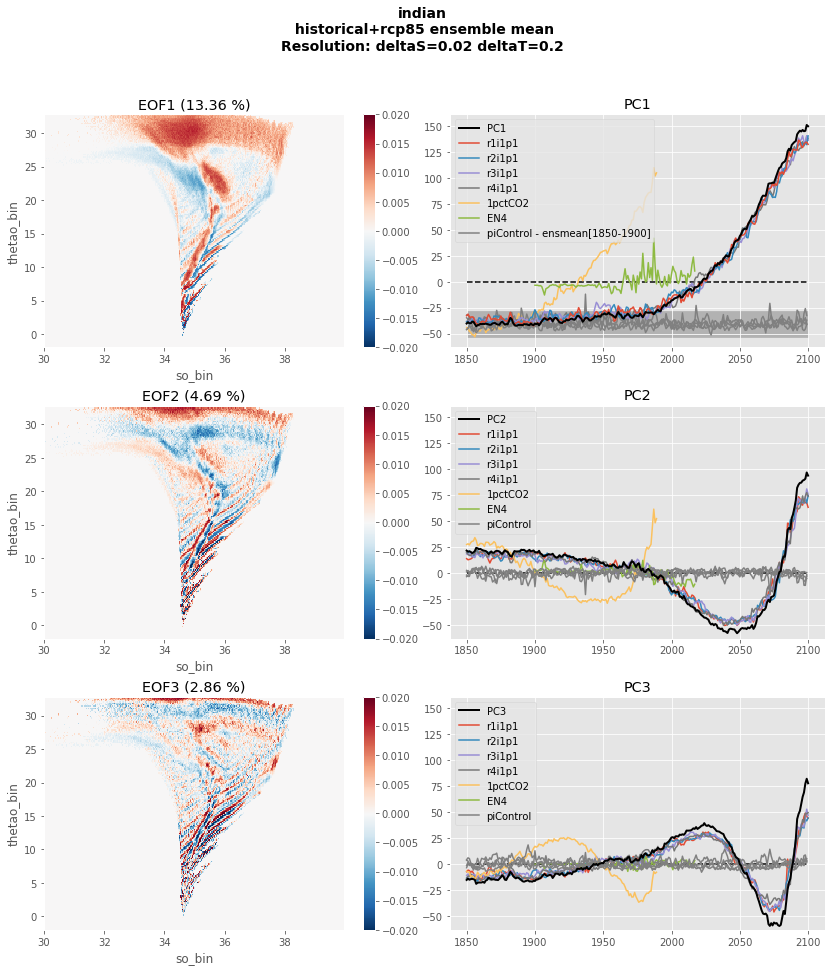

In [23]:
plot_eof_basin(3,solver_ind,pseudo_pcs_1_ind,pseudo_pcs_2_ind,pseudo_pcs_3_ind,pseudo_pcs_4_ind,
                pseudo_pcs_piC1_ind,pseudo_pcs_piC2_ind,pseudo_pcs_piC3_ind,pseudo_pcs_piC4_ind,
               pseudo_pcs_CO2_ind,pseudo_pcs_EN4_ind)